The path to the notebook is: /home/ucecabj/Desktop/MFI_git/MFI_class1D
The data folder is: /home/ucecabj/Desktop/MFI_git/MFI_class1D/_data_SRTR/
The MFI grid was: 
xmin= -6.0  xmax= 6.0  nx= 501

The new PLUMED grid is: 
pl_xmin= -7.01  pl_xmax= 7.01  pl_nx= 585


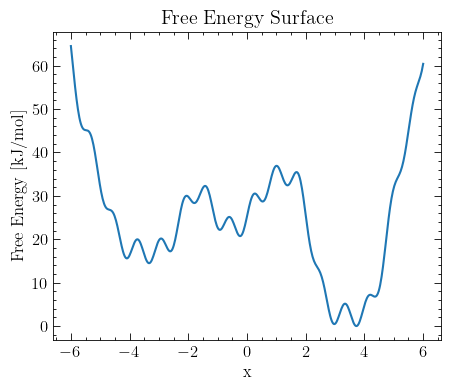

In [2]:
# Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import os
from scipy.interpolate import interp1d

# Import the MFI library 
import MFI_lib1D as lib1
import MFI_class1D

# Set the path to the notebook and the data folder (and figures folder if needed)
if 'path_notebook' not in globals(): path_notebook = os.getcwd()
print("The path to the notebook is:", path_notebook)

if 'path_data' not in globals():
    if not os.path.isdir("_data_SRTR"): print("\nThe data folder \"_data_SRTR\" does not exist. Creating new folder."); os.mkdir(path_notebook + "/_data_SRTR/"); 
    path_data = path_notebook + "/_data_SRTR/"
print("The data folder is:", path_data)
# path_figures = "/home/ucecabj/Pictures/MFI_figures/"

# Set the plotting parameters
for _plt_parameters_ in [0]:
    from matplotlib import rc
    plt.rcParams.update({ "text.usetex": True, "font.family": "serif", "font.serif": ["Helvetica"], "font.size": 12, "axes.titleweight": "bold"})
    plw = 0.6  # width of (box line, tick line, ...)
    plt.rcParams.update({"axes.linewidth": plw, "figure.figsize": (4,3)}) 
    plt.rcParams.update({"xtick.top": True, "xtick.direction": "in", "xtick.major.width": plw, "xtick.minor.width": plw, "xtick.minor.visible": True, "xtick.major.size": 5})
    plt.rcParams.update({"ytick.right": True, "ytick.direction": "in", "ytick.major.width": plw, "ytick.minor.width": plw, "ytick.minor.visible": True, "ytick.major.size": 5})


# Load the grid, the FES, and the PLUMED grid. Change n_surf to select the surface.  
for _surf_parameters_ in [0]:
    [grid, y_list, y_string_list] = lib1.load_pkl(path_notebook + "/fes_list_1D")
    FES_cutoff_list = [30, 40, 40, 50, 50, 80, 60, 70, 70, 80, 80, 90, 80, 90, 90, 100, 100, 100, 110, 110]
    n_surf = 4
    y = y_list[n_surf]
    FES_cutoff = FES_cutoff_list[n_surf]
    y_string = y_string_list[n_surf]  
    dx, dy = grid[1] - grid[0], np.gradient(y, grid[1] - grid[0]) 
    [pl_x, pl_min, pl_max, pl_n, pl_ext] = lib1.get_plumed_grid_1D(grid, -7, 7, print_info=True)
    plt.figure(figsize=(5,4)); plt.plot(grid, y); plt.xlabel("x"); plt.ylabel("Free Energy [kJ/mol]"); plt.title("Free Energy Surface"); plt.show()

In [13]:
### Reload modules
os.chdir(path_notebook); reload(MFI_class1D); reload(lib1); pass

### Define default parameters

In [7]:
default_params = {	"grid":grid, "y":y, "bw":dx*1.5, "periodic":False, # "dy":dy, "initial_position":[0,0], 
					"System":y_string, "pl_grid":pl_x, "position_pace":50, "metad_pace":500, "n_pos_per_window":10, 
         			"Bias_sf":1.05, "gaus_filter_sigma":1, 
					"FES_cutoff":FES_cutoff, 
                    # "calculate_FES_st_dev":True, "bootstrap_iter":50,
                    "save_mfi_instance":True, "simulation_folder_path": path_data}

### Run test SRTR (Single Real-Time ReInitialisation) simulation

Loading simulation folder: simulation_test_1
testing loading data from hills, pos and external_bias.dat. Remove 1==2 to try to load force terms
force terms file not found. Calculating force terms without external bias. 
Loading simulation folder: simulation_test_2
testing loading data from hills, pos and external_bias.dat. Remove 1==2 to try to load force terms
force terms file not found. Calculating force terms with external bias. 
Loading simulation folder: simulation_test_3
testing loading data from hills, pos and external_bias.dat. Remove 1==2 to try to load force terms
force terms file not found. Calculating force terms with external bias. 
Loading simulation folder: simulation_test_4
testing loading data from hills, pos and external_bias.dat. Remove 1==2 to try to load force terms
force terms file not found. Calculating force terms with external bias. 
Loading simulation folder: simulation_test_5
testing loading data from hills, pos and external_bias.dat. Remove 1==2 to try to lo

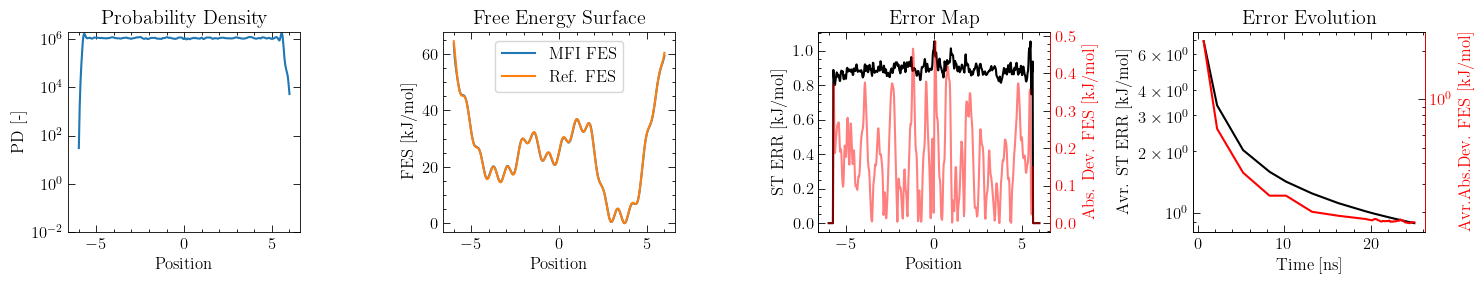


~~~~~~ END ~~~~~~

MFI.Aofe = 0.8926, MFI.AAD = 0.1724


In [15]:
# Prepare the MFI object
MFI = MFI_class1D.MFI1D(**default_params)

# Run simulation with real time analysis and re-initialisation
MFI.MFI_real_time_ReInit(ID="_test", goal=0.01, main_error_type="AAD", n_pos_before_analysis=500, guaranteed_sim_time=3, max_sim_time=5, ### time units [ns] , with metad_pace=500 -> 1ns ~ 400 hills
                        #  time_budget=10)  # use this for starting a SRTR-campaign for 0 ns.  
                         restart_SRTR=True, time_budget=25)  # use this for re-starting a SRTR-campaign from existing data.

# Plot+print the final results
MFI.plot_results()
print(f"\n~~~~~~ END ~~~~~~\n\n{MFI.Aofe = :.4f}, {MFI.AAD = :.4f}")


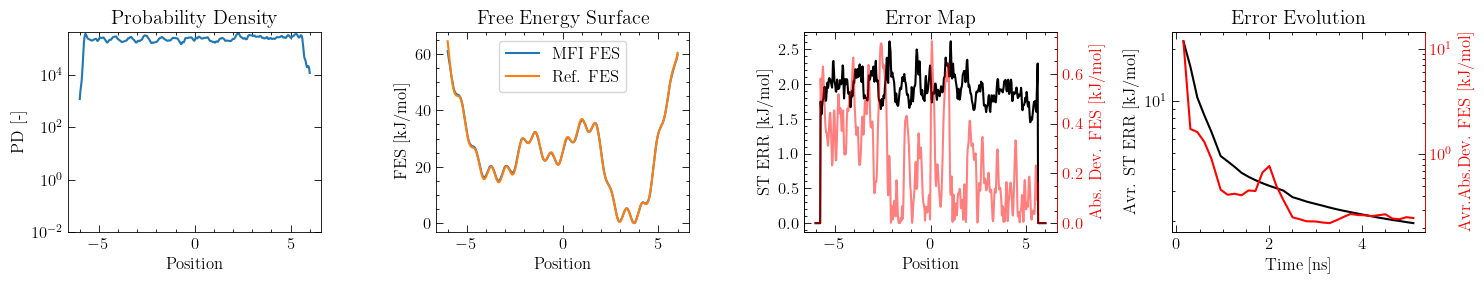

MFI_reload.Aofe = 1.9465, MFI_reload.AAD = 0.2499


In [3]:
### if save_mfi_instance = True, we can reload the instance and plot the results or access the force terms, ...

# specify the path to the instance
mfi_instance_path = path_data + "SRTRcampaign_test/MFI_instance_test.pkl"

MFI_reload = MFI_class1D.load_instance(mfi_instance_path)

MFI_reload.plot_results()
print(f"{MFI_reload.Aofe = :.4f}, {MFI_reload.AAD = :.4f}")

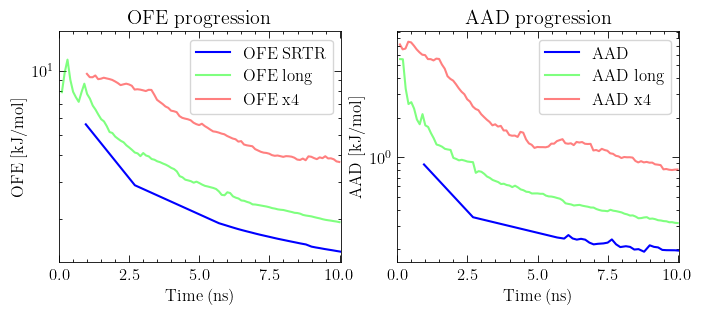

In [11]:
### plot convergence and compare with long and x4 simulations
plot_twin_axis = False

[time_l, ofe_mean_l, ofe_ste_l, aad_mean_l, aad_ste_l] = lib1.load_pkl(path_notebook + "/error_progressions/error_progression_long_10ns")
[time_p, ofe_mean_p, ofe_ste_p, aad_mean_p, aad_ste_p] = lib1.load_pkl(path_notebook + "/error_progressions/error_progression_x4_10ns"  )

t = np.array(MFI.Avr_Error_list)[:, 0]
ofe = np.array(MFI.Avr_Error_list)[:, 2]
aad = np.array(MFI.Avr_Error_list)[:, MFI.aad_index]

if not plot_twin_axis:
    plt.figure(figsize=(8,3)); plt.subplot(1,2,1); 
    plt.plot(t, ofe, label="OFE SRTR", color="blue")
    plt.plot(time_l, ofe_mean_l, label="OFE long", color="lime", alpha=0.5)
    plt.plot(time_p, ofe_mean_p, label="OFE x4", color="red", alpha=0.5)
    # for i in range(1, len(MFI.tot_time)): plt.axvline(x=sum(MFI.tot_time[1:i+1]), color="blue", linestyle="--", alpha=0.5, linewidth=1)
    plt.yscale("log"); 
    plt.xlim(0, max(t)); plt.legend(); plt.title("OFE progression"); plt.xlabel("Time (ns)"); plt.ylabel("OFE [kJ/mol]")

    plt.subplot(1,2,2)
    plt.plot(t, aad, label="AAD", color="blue")
    plt.plot(time_l, aad_mean_l, label="AAD long", color="lime", alpha=0.5)
    plt.plot(time_p, aad_mean_p, label="AAD x4", color="red", alpha=0.5)
    # for i in range(1, len(MFI.tot_time)): plt.axvline(x=sum(MFI.tot_time[1:i+1]), color="blue", linestyle="--", alpha=0.5, linewidth=1)
    plt.yscale("log"); 
    plt.xlim(0, max(t)); plt.legend(); plt.title("AAD progression"); plt.xlabel("Time (ns)"); plt.ylabel("AAD [kJ/mol]") 
    plt.show()

else:
    option = False
    plt.figure(figsize=(8,8))
    plt.plot(np.insert(t, 0, 0), np.insert(ofe, 0, 15), label="OFE SRTR", color="blue", linewidth=5, alpha=0.5, linestyle="--")
    plt.plot(np.insert(time_l, 0, 0), np.insert(ofe_mean_l, 0, 15), label="OFE long", color="lime", linewidth=5, alpha=0.4)
    plt.plot(np.insert(time_p, 0, 0), np.insert(ofe_mean_p, 0, 15), label="OFE x4", color="red", linewidth=5, alpha=0.2)
    # for i in range(1, len(MFI.tot_time)): plt.axvline(x=sum(MFI.tot_time[1:i+1]), color="blue", linestyle="--", alpha=0.5, linewidth=1)
    plt.yscale("log") if option is False else plt.ylim(0, 0.4692*30)
    plt.legend(); plt.title("Error progression"); plt.xlabel("Time (ns)"); plt.ylabel("OFE [kJ/mol]")
    plt.gca().twinx()
    plt.plot(np.insert(t, 0, 0), np.insert(aad, 0, 10), label="AAD", color="blue")
    plt.plot(np.insert(time_l, 0, 0), np.insert(aad_mean_l, 0, 10), label="AAD long", color="lime", alpha=0.5)
    plt.plot(np.insert(time_p, 0, 0), np.insert(aad_mean_p, 0, 10), label="AAD x4", color="red", alpha=0.5)
    plt.yscale("log") if option is False else plt.ylim(0, 0.0411*30) 
    plt.ylabel("AAD [kJ/mol]") 
    plt.show()

# MFI.plot_results()


### Run Multiple Long Simulations and analysis (for statistical analysis)

In [ ]:
os.chdir(path_notebook); reload(MFI_class1D); reload(lib1); pass

In [ ]:
default_params = {	"grid":grid, "y":y, "bw":dx*1.5, "periodic":False, # "dy":dy, "initial_position":[0,0], 
					"System":y_string, "pl_grid":pl_x, "position_pace":50, "metad_pace":500, "n_pos_per_window":10, 
         			"Bias_sf":1.05, "gaus_filter_sigma":1, 
					"FES_cutoff":FES_cutoff, "calculate_FES_st_dev":True, "bootstrap_iter":50,
     				"simulation_folder_path": path_data, "print_info": False}

In [ ]:
n_campaigns = 15
min_sim_time, max_sim_time, time_budget = 10, 20, 100

# Loop over all surfaces
# for n_surf in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]:
# for n_surf in range(20):
for n_surf in [4]:
    
    # Set the surface
    y, y_string, FES_cutoff = y_list[n_surf], y_string_list[n_surf], FES_cutoff_list[n_surf]
    print(f"\n~~~~~~ Surface {n_surf} ~~~~~~")

    # loop over campaigns
    for i in range(1,n_campaigns+1):
        
        # Set the path to the campaign folder and the campaign ID
        print(f"~~~~~~ Simulation {i} ~~~~~~")
        new_path = path_data + f"S{n_surf}/"
        camp_ID = f"_{i}_{time_budget}ns"
        path_campaign = new_path + f"SRTRcampaign{camp_ID}/"
        
        #check if directory exists. If does not exist, create it and move to it.
        if os.path.isdir(path_campaign): pass
        else: os.mkdir(path_campaign)
        os.chdir(path_campaign)
        
        # check if error progression file exists. If it does, skip this iteration, otherwise run the campaign.
		if os.path.isfile(path_camp + f"error_progression{camp_ID}"): print(f"File error_progression{camp_ID} already exists. Skipping this iteration."); continue	
		else: print(f"S{n_surf}: Running campaign {i} of {total_campaigns} ")    
      
        ## Prepare MFI object
        new_params = default_params.copy()
        new_params.update({"simulation_folder_path":new_path, "y":y, "System":y_string, "FES_cutoff":FES_cutoff})             
        MFI = MFI_class1D.MFI1D(**new_params)
        
        ## Run campaign
		MFI.MFI_real_time_ReInit(ID=camp_ID, goal=0.01, goal_type="AAD", n_pos_before_analysis=500, 
								guaranteed_sim_time=min_sim_time, max_sim_time=max_sim_time, time_budget=time_budget)### time units [ns] , with metad_pace=500 -> 1ns ~ 400 hills

		## Print final error and save error progression
		print(f"~~~~ End of campaign ~~~~\n{MFI.Aofe = :.4f}, {MFI.AAD = :.4f}\n\n")
		lib1.save_pkl([list(MFI.Avr_Error_list[:, 0]), list(MFI.Avr_Error_list[:, 2]), list(MFI.Avr_Error_list[:, MFI.aad_index])], path_camp + f"error_progression{camp_id}")




~~~~~~ Surface 0 ~~~~~~

~~~~~~ Surface 1 ~~~~~~

~~~~~~ Surface 2 ~~~~~~

~~~~~~ Surface 3 ~~~~~~

~~~~~~ Surface 4 ~~~~~~

~~~~~~ Surface 5 ~~~~~~

~~~~~~ Surface 6 ~~~~~~

~~~~~~ Surface 7 ~~~~~~

~~~~~~ Surface 8 ~~~~~~

~~~~~~ Surface 9 ~~~~~~

~~~~~~ Surface 10 ~~~~~~

~~~~~~ Surface 11 ~~~~~~

~~~~~~ Surface 12 ~~~~~~

~~~~~~ Surface 13 ~~~~~~

~~~~~~ Surface 14 ~~~~~~

~~~~~~ Surface 15 ~~~~~~

~~~~~~ Surface 16 ~~~~~~

~~~~~~ Surface 17 ~~~~~~

~~~~~~ Surface 18 ~~~~~~

~~~~~~ Surface 19 ~~~~~~


NameError: name 'total_campaigns' is not defined

### Calculate and plot average error progression

t=[0.55,100.01] | Final avr: AOFE=0.472, AAD=0.052


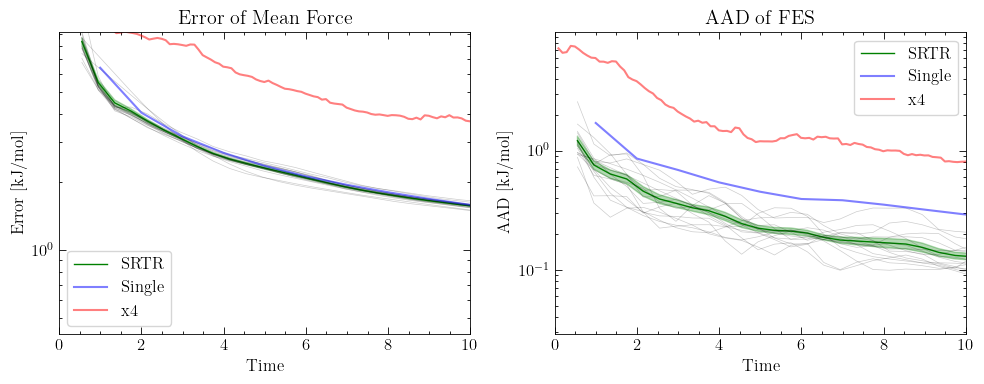

In [21]:
# n_surf = 15
# total_campaigns = 20
# time_budget = 10

n_surf = 4
total_campaigns = 15
time_budget = 100

# calculate and plot the average error progression
lib1.get_avr_error_prog(path_data, n_surf=n_surf, total_campaigns=total_campaigns, time_budget=time_budget, simulation_type="SRTR", show_plot=False, line_label="SRTR")

# plot the average error progression of the long and 4-patallel simulations
[time_l, ofe_mean_l, ofe_ste_l, aad_mean_l, aad_ste_l] = lib1.load_pkl(path_notebook + "/error_progressions/error_progression_long")
[time_p, ofe_mean_p, ofe_ste_p, aad_mean_p, aad_ste_p] = lib1.load_pkl(path_notebook + "/error_progressions/error_progression_x4_10ns"  )
plt.subplot(1,2,1); plt.plot(time_l, ofe_mean_l, label="Single", color="blue", alpha=0.5); plt.plot(time_p, ofe_mean_p, label="x4", color="red", alpha=0.5); plt.legend(); plt.xlim(0, 10); 
plt.subplot(1,2,2); plt.plot(time_l, aad_mean_l, label="Single", color="blue", alpha=0.5); plt.plot(time_p, aad_mean_p, label="x4", color="red", alpha=0.5); plt.legend(); plt.xlim(0, 10); 
plt.tight_layout(); plt.show()
